<a href="https://colab.research.google.com/github/flying-bear/kompluxternaya/blob/master/new_assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 9

Use data from `https://github.com/thedenaas/hse_seminars/tree/master/2018/seminar_13/data.zip`  
Implement model in pytorch from ["An Unsupervised Neural Attention Model for Aspect Extraction, He et al, 2017"](https://www.comp.nus.edu.sg/~leews/publications/acl17.pdf), also desribed in seminar notes.  


You can use sentence embeddings with attention **[7 points]**:  
$z_s = \sum_{i}^n \alpha_i e_{w_i}, z_s \in R^d$ sentence embedding  
$\alpha_i = softmax(d_i)$  attention weight for i-th token  
$d_i = e_{w_i}^T M y_s$ attention with trainable matrix $M \in R^{dxd}$  
$y_s = \frac 1 n \sum_{i=1}^n e_{w_i}, y_s \in R^d$ sentence context  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  

**Or** just use sentence embedding as an average over word embeddings **[5 points]**:  
$z_s = \frac 1 n \sum_{i=1}^n e_{w_i}, z_s \in R^d$ sentence embedding  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  
 
$p_t = softmax(W z_s + b), p_t \in R^K$ topic weights for sentence $s$, with trainable matrix $W \in R^{dxK}$ and bias vector $b \in R^K$  
$r_s = T^T p_t, r_s \in R^d$ reconstructed sentence embedding as a weighted sum of topic embeddings   
$T \in R^{Kxd}$ trainable matrix of topic embeddings, K=number of topics


**Training objective**:
$$ J = \sum_{s \in D} \sum_{i=1}^m max(0, 1-r_s^T z_s + r_s^T n_i) + \lambda ||T^T T - I ||^2_F  $$
where   
$m$ random sentences are sampled as negative examples from dataset $D$ for each sentence $s$  
$n_i = \frac 1 n \sum_{i=j}^n e_{w_j}$ average of word embeddings in the i-th sentence  
$||T^T T - I ||_F$ regularizer, that enforces matrix $T$ to be orthogonal  
$||A||^2_F = \sum_{i=1}^N\sum_{j=1}^M a_{ij}^2, A \in R^{NxM}$ Frobenius norm


**[3 points]** Compute topic coherence for at least for 3 different number of topics. Use 10 nearest words for each topic. It means you have to train one model for each number of topics. You can use code from seminar notes with word2vec similarity scores.

## Get data

In [1]:
!wget -O data.zip https://github.com/thedenaas/hse_seminars/blob/master/2018/seminar_13/data.zip?raw=true 

--2020-03-22 12:47:05--  https://github.com/thedenaas/hse_seminars/blob/master/2018/seminar_13/data.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/thedenaas/hse_seminars/raw/master/2018/seminar_13/data.zip [following]
--2020-03-22 12:47:05--  https://github.com/thedenaas/hse_seminars/raw/master/2018/seminar_13/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thedenaas/hse_seminars/master/2018/seminar_13/data.zip [following]
--2020-03-22 12:47:05--  https://raw.githubusercontent.com/thedenaas/hse_seminars/master/2018/seminar_13/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

In [2]:
!unzip data.zip

Archive:  data.zip
replace data.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace stopwords.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## video memeory?


In [3]:
!nvidia-smi

Sun Mar 22 12:47:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
import gensim
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torchtext.data import Field, TabularDataset, Iterator

from itertools import combinations
from scipy.ndimage.filters import gaussian_filter1d
from tqdm import tqdm, tqdm_notebook

In [0]:
batch_size = 256
random_state = 42
num_neg_samples = 5
num_topics = 5

In [0]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else tt.device('cpu')

## Data

In [8]:
with open('data.txt', 'r') as f:
  text = f.read()
print(text[:100])

Barclays' defiance of US fines has merit Barclays disgraced itself in many ways during the pre-finan


In [9]:
len(text.split('/n'))

13

In [0]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower())

### add negative samples


In [0]:
df = pd.DataFrame()
df['pos'] = sent_tokenize(text)
df['pos'] = df['pos'].apply(lambda x: re.sub('\&[lg]t;', '', x))

In [15]:
df.tail()

,pos
183395,It feels as though Stone realised that some of...
183396,"There are some fun elements, many involving Rh..."
183397,I particularly enjoyed a scene in which O’Bria...
183398,His carnivorous snarl fills the immense screen...
183399,There’s a playful visual flair to this moment ...


In [0]:
def add_negative(df):
  neg_id = np.random.choice(len(df))
  return df.iloc[neg_id, 0]

In [0]:
for i in range(num_neg_samples):
  df[f'neg{i}'] = df['pos'].apply(lambda x: add_negative(df))

In [18]:
df.tail()

,pos,neg0,neg1,neg2,neg3,neg4
183395,It feels as though Stone realised that some of...,It wasn’t tweaked to achieve that low-register...,"Shingrix, a new shingles vaccine which is seen...",29 min A Hollywood move from United: Pogba’s d...,• ■ If a drug could be found to slow cognitive...,“But something’s about to happen that you aren...
183396,"There are some fun elements, many involving Rh...","Staffers are reportedly working without pay, b...","Different towns, same message: “There’s no dec...",And less than 24 hours after Trump dismissed C...,Idaho Primaries: Democratic presidential caucu...,What happens now?
183397,I particularly enjoyed a scene in which O’Bria...,"At least an hour prior, a campaign staffer was...","For Pickford, a reluctant traveller, that mean...",So what does this nonpartisan Reno resident – ...,"It’s common, they say, for pilots to live far ...",“It’s quite logical.” Amy Lawrence Match repor...
183398,His carnivorous snarl fills the immense screen...,"Instead, the Trump campaign embarked on a dama...",Cue a romantic montage of Peppa and Woody jump...,Tottenham haven’t had a meaningful attempt on ...,Scottish Premiership: Niall McGinn has equalis...,Maybe that’ll be different.” Since Trump seems...
183399,There’s a playful visual flair to this moment ...,Wildlife losses are expected to continue throu...,"It’s the same with cigarettes, pastries, caffe...","Cattermole did put his hand on Bassong’s back,...","Household incomes surged 5.2% last year, the l...",If religious leaders say it is right for a gir...


In [0]:
df.to_csv('text.csv', index=False)

### Batch

In [0]:
TEXT = Field(include_lengths=False, 
             batch_first=True, 
             tokenize=lambda x: re.findall('\w+', x.lower()),
             stop_words=custom_stop_words)

datafields = [('pos',TEXT), *[(f'neg{i}', TEXT) for i in range(num_neg_samples)]]

In [0]:
trn = TabularDataset(path="text.csv",
                     format='csv',
                     skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                     fields=datafields)

In [0]:
TEXT.build_vocab(trn)

In [0]:
vocab_size = len(TEXT.vocab.itos) 

### Iterator

In [0]:
trn_itr = Iterator(trn, batch_size, device=DEVICE, shuffle=True)

In [25]:
example_batch = next(iter(trn_itr))
example_batch


[torchtext.data.batch.Batch of size 256]
	[.pos]:[torch.cuda.LongTensor of size 256x58 (GPU 0)]
	[.neg0]:[torch.cuda.LongTensor of size 256x66 (GPU 0)]
	[.neg1]:[torch.cuda.LongTensor of size 256x76 (GPU 0)]
	[.neg2]:[torch.cuda.LongTensor of size 256x58 (GPU 0)]
	[.neg3]:[torch.cuda.LongTensor of size 256x51 (GPU 0)]
	[.neg4]:[torch.cuda.LongTensor of size 256x65 (GPU 0)]

## Neural Network

just use sentence embedding as an average over word embeddings **[5 points]**:  
$z_s = \frac 1 n \sum_{i=1}^n e_{w_i}, z_s \in R^d$ sentence embedding  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  
(implemented with ```nn.EmbeddingBag```)

$p_t = softmax(W z_s + b), p_t \in R^K$ topic weights for sentence $s$, with trainable matrix $W \in R^{dxK}$ and bias vector $b \in R^K$  
$r_s = T^T p_t, r_s \in R^d$ reconstructed sentence embedding as a weighted sum of topic embeddings   
$T \in R^{Kxd}$ trainable matrix of topic embeddings, K=number of topics


In [26]:
pad_id = TEXT.vocab.stoi['<pad>']
pad_id

1

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, emb_dim=300, topic_dim=num_topics):
      super(MyModel, self).__init__()
      self.embedding = nn.EmbeddingBag(vocab_size, emb_dim)  ## how do I ignore the padding?
      self.pt = nn.Linear(emb_dim, topic_dim)
      self.soft = F.softmax
      self.rs = nn.Linear(topic_dim, emb_dim, bias=False)

    def forward(self, batch):
      vecs_true = self.embedding(batch.pos)
      x = self.pt(vecs_true)
      x = self.soft(x)
      vecs_rec = self.rs(x) 
      
      negs = [self.embedding(batch.neg0), 
              self.embedding(batch.neg1), 
              self.embedding(batch.neg2),
              self.embedding(batch.neg3),
              self.embedding(batch.neg4),]  ## how do I generalize this to different num_neg_samples?
      negs = torch.stack(negs, dim=-1)

      return vecs_rec, vecs_true, negs

In [28]:
model = MyModel(vocab_size)
model = model.to(DEVICE)
vecs_rec, vecs_true, negs = model(example_batch)
vecs_rec.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


torch.Size([256, 300])

In [29]:
vecs_true.shape

torch.Size([256, 300])

In [30]:
negs.shape

torch.Size([256, 300, 5])

In [31]:
list(model.parameters())[0].shape

torch.Size([72172, 300])

In [32]:
model.embedding.weight.shape

torch.Size([72172, 300])

## Loss
**Training objective**:

$$ J = \sum_{s \in D} \sum_{i=1}^m max(0, 1-r_s^T z_s + r_s^T n_i) + \lambda ||T^T T - I ||^2_F  $$
where   
$m$ random sentences are sampled as negative examples from dataset $D$ for each sentence $s$  
$n_i = \frac 1 n \sum_{i=j}^n e_{w_j}$ average of word embeddings in the i-th sentence  
$||T^T T - I ||_F$ regularizer, that enforces matrix $T$ to be orthogonal  
$||A||^2_F = \sum_{i=1}^N\sum_{j=1}^M a_{ij}^2, A \in R^{NxM}$ Frobenius norm

In [0]:
class MyLoss(nn.Module):
  def __init__(self, lmbd=0.01):
    super(MyLoss, self).__init__()  
    self.lmbd = lmbd

  def forward(self, vecs_true, negs, vecs_rec, T):
    vecs_true = vecs_true.unsqueeze(1) ## add dimension for bmm
    rs = vecs_rec.unsqueeze(1) ## add dimension for bmm
    rsT = rs.permute(0, 2, 1) ## transpose
    rsTzs = torch.bmm(rsT, vecs_true)
    negs_losses = []
    for ni in negs.permute(2, 0, 1):  ## so that we iterate over the neg samples
      ni = ni.unsqueeze(1) ## add dimension for bmm
      negs_losses.append(torch.bmm(rsT, ni))
    losses = []
    for n_loss in negs_losses:
      tmp = (1 - rsTzs + n_loss).squeeze(1)
      zeros = torch.zeros_like(tmp).to(DEVICE)
      values, idx = torch.max(torch.stack([tmp, zeros]), 0)
      losses.append(values)
    losses = torch.stack(losses, dim=-1)
    reg_0 = torch.mm(T.permute(1,0), T)
    reg = self.lmbd  * (torch.norm(reg_0 - torch.eye(reg_0.shape[0]).to(DEVICE), p='fro')) #
    return torch.mean(losses) + reg  ## instead of sum I use mean

In [35]:
criterion = MyLoss()
criterion.to(DEVICE)
criterion(vecs_true, negs, vecs_rec, model.embedding.weight)

tensor(12524.7168, device='cuda:0', grad_fn=<AddBackward0>)

## Train

In [0]:
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters())

In [0]:
def train_epoch(data_iter, len_iter, n_epoch, model, criterion, optimizer=None):
    train_losses = []
    total_loss = 0
    data_iter = tqdm_notebook(data_iter, total=len_iter, desc=f"Epoch {n_epoch + 1}", leave=True)
    counter = 0
    for batch in data_iter:
        if optimizer:
          optimizer.zero_grad()
        vecs_rec, vecs_true, negs = model.forward(batch)
        loss = criterion(vecs_true, negs, vecs_rec, model.embedding.weight)
        loss.backward()
        if optimizer:
          optimizer.step()
        loss_value = loss.detach().item()
        total_loss += loss_value
        train_losses.append(loss_value)
        data_iter.set_postfix(loss = loss_value)
        counter += 1
        
    total_loss /= counter
    return total_loss, train_losses

In [43]:
total_train_losses = []
total_valid_losses = []
for epoch in range(num_epochs):
    model.train()
    loss, train_losses = train_epoch(trn_itr, len(trn_itr), epoch, model, criterion, optimizer)
    total_train_losses += train_losses
    print('train', loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]



train 7525.930805711733



train 2477.140616827929



train 788.1512612910783



train 232.23369889944334



train 61.68342563198201


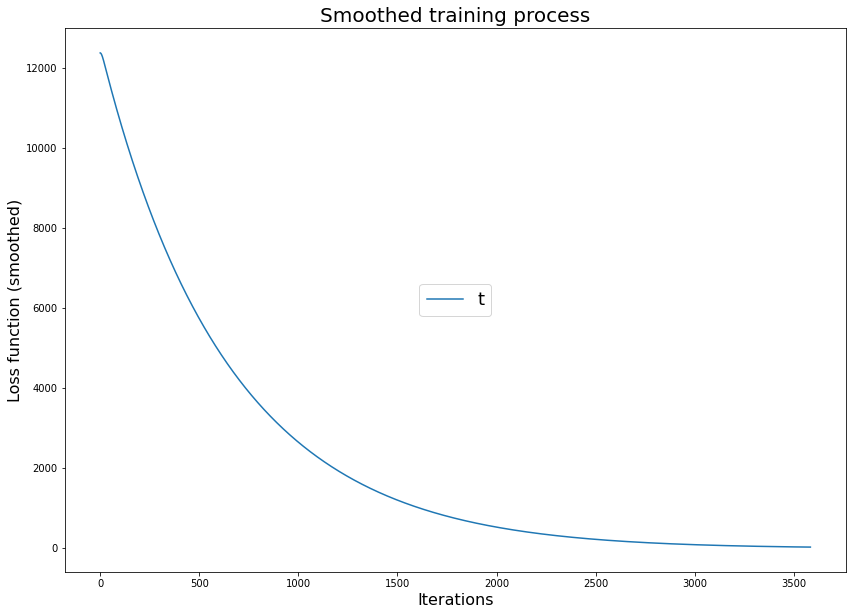

In [44]:
smooth = lambda y: gaussian_filter1d(y, sigma=10)

plt.figure(figsize=(14, 10))
plt.plot(range(len(total_train_losses)), smooth(total_train_losses))
plt.legend(('train loss'),
           loc='center', prop={'size': 18})
plt.title('Smoothed training process', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss function (smoothed)', fontsize=16)
plt.show()

## Topic Coherence

In [0]:
topic_embeddings = model.pt.weight

In [46]:
topic_embeddings.shape

torch.Size([5, 300])

In [0]:
word_embeddings = model.embedding.weight

In [48]:
word_embeddings.shape

torch.Size([72172, 300])

In [0]:
word2topic = torch.mm(word_embeddings, topic_embeddings.permute(1, 0))

In [50]:
word2topic.shape

torch.Size([72172, 5])

In [0]:
topic2word = word2topic.permute(1, 0)

In [52]:
topic2word.shape

torch.Size([5, 72172])

In [0]:
k = 25

In [0]:
topic_words = []
for i in range(num_topics):
  ids = torch.argsort(topic2word[i])[:k+1]
  words = [word for word in [TEXT.vocab.itos[x] for x in ids] if word != '<pad>']
  topic_words.append(words[:k])

In [77]:
topic_words[2]

['s',
 'trump',
 'i',
 'insuring',
 'humberside',
 'windu',
 'hiro',
 'snows',
 'tranquility',
 'voluntarysectornetwork',
 'stakeholder',
 'lexit',
 'hozier',
 'important',
 'yellows',
 'plunks',
 'sales',
 'srf',
 'eu',
 'netgear',
 'embroidery',
 'woolworths',
 'people',
 'win',
 'topical']

### compare with real embeddings proximity

In [61]:
wv = api.load('word2vec-google-news-300')
wv['king'][:10]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([ 0.12597656,  0.02978516,  0.00860596,  0.13964844, -0.02563477,
       -0.03613281,  0.11181641, -0.19824219,  0.05126953,  0.36328125],
      dtype=float32)

In [0]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.vocab and pair[1] in w2v_model.vocab:
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [78]:
calculate_coherence(wv, topic_words)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.06094594804148327